In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss
from model.model import LSTM
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

torch.manual_seed(0)

#### Import data and set quantiles

In [2]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# lookback periods
slide = 6

## LSTM USING ONLY THE TARGET

In [3]:
_data = pd.concat(
    [data['production'].shift(1).copy(), data['production']], 
    axis=1, 
    keys=['production_shift', 'production']
).dropna()

In [4]:
# intialize frametorch
frametorch = FrameTorch(_data)
# split data
frametorch.split_data()
# scale data
frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

#### MODEL PREPARATION

In [5]:
# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [6]:
# model
quantilenet = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=n_inputs, n_layers=1)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet.parameters(), lr=0.0001)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [7]:
quantilenet = trainer.fit(
    train_loader, val_loader, epochs=2000, n_logger=200, patience=50
)

epoch: 0 train loss: 2.844 val loss: 2.804
epoch: 200 train loss: 0.181 val loss: 0.189
epoch: 400 train loss: 0.166 val loss: 0.177
epoch: 600 train loss: 0.165 val loss: 0.177


### VALIDATION PREDICTIONS SPREAD vs NON SPREAD

In [8]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_all = FrameTorch(data_non_spread)
# split data
frametorch_all.split_data()
# scale data
frametorch_all.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

#### MODEL PREPARATION

In [11]:
# number of inputs and outputs
n_inputs = frametorch_all.data.shape[1] - 1
n_outputs = len(quantiles)

In [12]:
# model
quantilenet_all = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=n_inputs, n_layers=1)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_all.parameters(), lr=0.00003)
# trainer class
trainer_all = Trainer(quantilenet_all, criterion, optimizer)

#### TRAIN DE MODEL

In [13]:
quantilenet_all = trainer_all.fit(
    train_loader, val_loader, epochs=2000, n_logger=200, patience=50
)

epoch: 0 train loss: 0.911 val loss: 0.517
epoch: 200 train loss: 0.122 val loss: 0.122


## CHECK INPUTS

In [14]:
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

# validation input and target
inputs, target = val_loader.dataset.inputs, val_loader.dataset.target
y_test = pd.Series(target.squeeze().tolist())

# quantilenet predictions
y_pred_quantilenet = quantilenet(inputs)
y_preds_quantilenet = pd.DataFrame(y_pred_quantilenet.tolist())

Predictions without spread

In [15]:
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

# validation input and target
inputs, _ = val_loader.dataset.inputs, val_loader.dataset.target

# quantilenet predictions
y_pred_quantilenet_all = quantilenet_all(inputs)
y_preds_quantilenet_all = pd.DataFrame(y_pred_quantilenet_all.tolist())

### COMPARE MODEL TYPES

Convergence

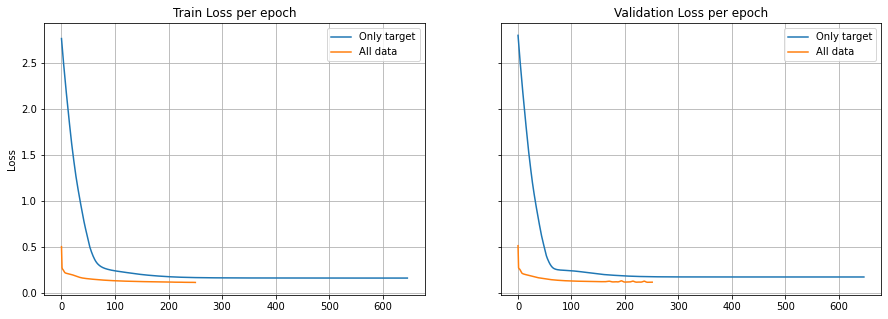

In [16]:
loss_ss = pd.Series(trainer.train_losses[1:])
validations_losses_ss = pd.Series(trainer.val_losses)

loss_ss_all = pd.Series(trainer_all.train_losses[1:])
validations_losses_ss_all = pd.Series(trainer_all.val_losses)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

loss_ss.plot(ax=ax[0])
loss_ss_all.plot(ax=ax[0])
validations_losses_ss.plot(ax=ax[1])
validations_losses_ss_all.plot(ax=ax[1])

ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[0].legend(['Only target', 'All data'])
ax[0].grid()

ax[1].set_title('Validation Loss per epoch')
ax[1].legend(['Only target', 'All data'])
ax[1].grid()

Scores

In [17]:
quantilenet_scores = get_scores(y_pred_quantilenet, target, quantiles)
quantilenet_all_scores = get_scores(y_pred_quantilenet_all, target, quantiles)

final_scores = pd.concat(
    [quantilenet_scores, quantilenet_all_scores], axis=1, keys=['Only target', 'All data']
)
final_scores

,Only target,All data
QS,0.169859,0.114678
IS,0.579096,0.391955
Sharpnees,0.390088,0.310949
ACE,3.091653,3.728485


Plots

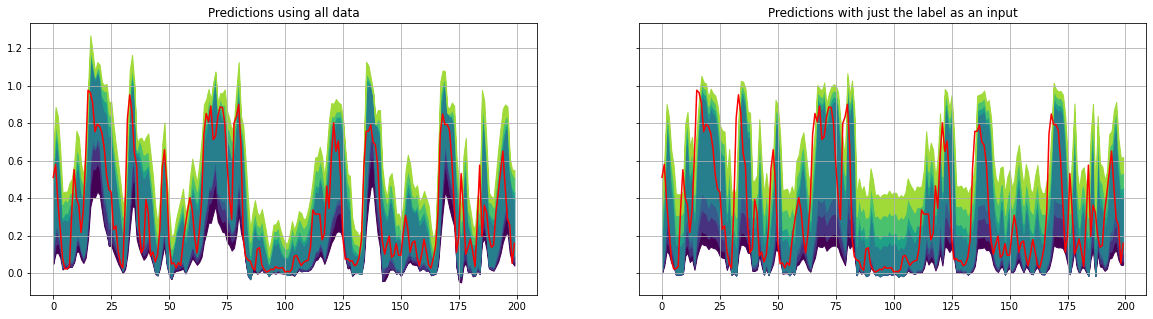

In [18]:
viridis = cm.get_cmap('viridis', len(quantiles))
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)

for i in range(len(y_preds_quantilenet_all.columns)-1):
    ax[0].fill_between(
        y_preds_quantilenet_all.index[:200], 
        y_preds_quantilenet_all[i][:200], 
        y_preds_quantilenet_all[i+1][:200], 
        color=viridis.colors[i]
    )  
y_test[:200].plot(color='red', ax=ax[0])
ax[0].set_title('Predictions using all data')
ax[0].grid()

for i in range(len(y_preds_quantilenet.columns)-1):
    ax[1].fill_between(
        y_preds_quantilenet.index[:200], 
        y_preds_quantilenet[i][:200], 
        y_preds_quantilenet[i+1][:200], 
        color=viridis.colors[i]
    )
y_test[:200].plot(color='red', ax=ax[1])
ax[1].set_title('Predictions with just the label as an input')
ax[1].grid()